In [1]:
#2/4 06:49
import numpy as np  
from numpy  import array
import pandas as pd
from keras.models import Sequential  
from keras.optimizers import RMSprop , Adam
from keras.layers import GaussianNoise, Dense , Conv2D , Activation , Dropout , Flatten , BatchNormalization , Reshape , UpSampling2D ,Conv2DTranspose,MaxPooling2D
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
import h5py
import os
from os import listdir
from os.path import isfile, isdir, join
from keras import backend as K
from PIL import Image
import sys
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'




Using TensorFlow backend.


In [2]:
batch_size = 128;

In [3]:
mypath = "fruit"
files = listdir(mypath)
label = 1
imglist = []
labellist= []
fruitname = []
for f in files:
    fullpath = join(mypath, f)
    print("目錄：", f)
    fruitname.append(f)
    files2 = listdir(fullpath)
    for f2 in files2:
        fullpath2 = join(fullpath, f2)
        img = Image.open(fullpath2)
        img = img.resize((96, 96), Image.ANTIALIAS)
        img = np.array(img)
        o = np.ones(img.shape)
        img = img - (o * 127.5) 
        img = img / 127.5
        img=img
        imglist.append(img)
        labellist.append(label)
    label = label + 1



目錄： 00Strawberry
目錄： 01Passion Fruit
目錄： 02Lemon
目錄： 03Pineapple
目錄： 04Pear
目錄： 05Carambula
目錄： 06Orange
目錄： 07Pitahaya Red
目錄： 08Kiwi
目錄： 09Grape White
目錄： 10Plum
目錄： 11Litchi
目錄： 12Apple
目錄： 13Mandarine
目錄： 14Pomegranate
目錄： 15Cherry
目錄： 16Guava
目錄： 17Banana
目錄： 18Grape Pink
目錄： 19Peach


In [6]:
combined = list(zip(imglist, labellist))
random.shuffle(combined)
imglist[:], labellist[:] = zip(*combined)
#print(imglist[1888])
#print(labellist[1888])

In [7]:
RealY = np_utils.to_categorical(labellist,num_classes=21)
RealY = RealY*0.85
RealY

array([[ 0.  ,  0.  ,  0.85, ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.  ,  0.  ,  0.  , ...,  0.85,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [8]:
#鑑定器 D
# In: 64 x 64 x 3, depth = 3
modelD = Sequential()

modelD.add(Conv2D(filters=32, strides=2 , kernel_size=(3, 3), padding='same', input_shape=(96, 96, 3)))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=64, strides=2 , kernel_size=(3, 3), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=128, strides=2 , kernel_size=(3, 3), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=256, strides=2 , kernel_size=(5, 5), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=512, strides=2 , kernel_size=(5, 5), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))
           
#modelD.add(Dropout(0.2))
modelD.add(Flatten())
modelD.add(Dense(21))
modelD.add(Activation('softmax'))
modelD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
__________

In [19]:
#生成器 G
# In: 512
modelG = Sequential()
modelG.add(Dense(12*12*256, input_dim=120))
modelG.add(Activation('relu'))
#modelG.add(Dropout(0.3))
modelG.add(Reshape((12, 12, 256)))
modelG.add(Conv2DTranspose(256, kernel_size = (5,5), strides=(2, 2), padding='same'))
modelG.add(BatchNormalization())
modelG.add(Activation('relu'))

modelG.add(Conv2DTranspose(128, kernel_size = (5,5), strides=(2, 2), padding='same'))
modelG.add(BatchNormalization())
modelG.add(Activation('relu'))

modelG.add(Conv2DTranspose(64, kernel_size = (3,3), strides=(2, 2), padding='same'))
modelG.add(BatchNormalization())
modelG.add(Activation('relu'))

modelG.add(Conv2DTranspose(3, kernel_size = (3,3), strides=(1, 1), padding='same'))
#modelG.add(BatchNormalization())
modelG.add(Activation('tanh'))
modelG.add(Reshape((96, 96, 3)))
modelG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 36864)             4460544   
_________________________________________________________________
activation_7 (Activation)    (None, 36864)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 24, 24, 256)       1638656   
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 24, 256)       1024      
_________________________________________________________________
activation_8 (Activation)    (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 48, 48, 128)       819328    
__________

In [20]:
#D
optimizerD = Adam(0.0002, 0.5)
modelTD = Sequential()
modelTD.add(modelD)
modelTD.compile(loss='binary_crossentropy', optimizer=optimizerD,metrics=['accuracy'])
#A1
optimizerA = Adam(0.00015, 0.5)
modelTA = Sequential()
modelTA.add(modelG)
modelTA.add(modelTD)
modelTD.trainable = False
modelTA.compile(loss='binary_crossentropy', optimizer=optimizerA,metrics=['accuracy'])

In [21]:
a_loss_record = []
d_loss_record = []
dF_loss_record = []
dR_loss_record = []

In [22]:
def TrainG():
    Fake_Lable = np.random.randint(0, 20, batch_size)
    Fake_Lable = np_utils.to_categorical(Fake_Lable,num_classes=20)
    noise = np.random.uniform(-0.8, 0.8, size=[batch_size, 100]) 
    NT = np.hstack((Fake_Lable,noise))
    #YA = np.ones([batch_size, 1])
    #YA = YA  * 0.85
    YA = Fake_Lable * 0.85
    YA = np.hstack((np.zeros([batch_size, 1]),YA))
    a_loss = modelTA.train_on_batch(NT,YA)
    a_loss_record.append(a_loss[0])
    print ("A1")
    print (a_loss)
    return a_loss

In [23]:
def TrainD():
    Rnd = np.random.randint(0,len(imglist),size = int(batch_size/2))
    newimglist = []
    for a in Rnd:
        newimglist.append(imglist[a])
    RealX = np.asarray(newimglist)
    YA = RealY[Rnd]    
    #YA = np.ones([int(batch_size/2), 1])
    YA = YA  * 0.85
    
    YZ = np.zeros([int(batch_size/2), 1])
    YZ = np_utils.to_categorical(YZ,num_classes=21)
    YZ = YZ  * 0.85
    
    Fake_Lable = np.random.randint(0, 20, int(batch_size/2))
    Fake_Lable = np_utils.to_categorical(Fake_Lable,num_classes=20)
    noise = np.random.uniform(-0.8, 0.8, size=[int(batch_size/2), 100]) 
    NT = np.hstack((Fake_Lable,noise))
    
    FakeX = modelG.predict(NT)
                                             
    gauss = np.random.normal(0,0.25,(int(batch_size/2),96,96,3))
    RealGX = RealX + gauss
    gauss = np.random.normal(0,0.25,(int(batch_size/2),96,96,3))
    FakeGX = FakeX + gauss 

    d_lossR = modelTD.train_on_batch(RealGX, YA)
    print ("D1R")
    print (d_lossR)
    d_lossF = modelTD.train_on_batch(FakeGX, YZ)
    print ("D1F")
    print (d_lossF)
    #
    d_loss =  (d_lossR[0] +  d_lossF[0]) / 2
    d_loss_record.append(d_loss)
  #  print ("D")
  #  print (d_loss)
    dR_loss_record.append(d_lossR[0])
    dF_loss_record.append(d_lossF[0])
    return d_loss
    

In [24]:
def Show(path):
    Fake_Lable = np.random.randint(0, 20, 1)
    k = Fake_Lable[0]
    Fake_Lable = np_utils.to_categorical(Fake_Lable,num_classes=20)
    noise = np.random.uniform(-0.8, 0.8, size=[1, 100]) 
    NT = np.hstack((Fake_Lable,noise))                                       
    FakeX = modelG.predict(NT)
    img = FakeX[0]
    img = img.reshape(96,96,3)
    img = img * 0.5 + 0.5
    plt.figure(figsize=(5,5))
    
    plt.title(fruitname[k])
    plt.imshow(img)
    plt.savefig(path)
    plt.show()
   

In [25]:
def ShowPlt():
    plt.plot(d_loss_record,label="d_loss")
    plt.plot(a_loss_record,label="a_loss")
    plt.plot(dR_loss_record,label="dR_loss")
    plt.plot(dF_loss_record,label="dF_loss")
    plt.legend()
    plt.show()


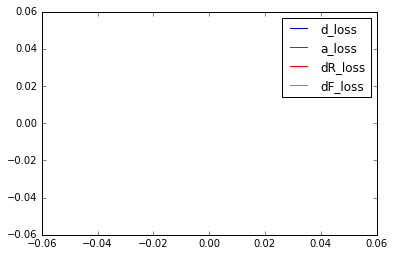

In [26]:
ShowPlt()

In [27]:
directory = 'img'
if not os.path.exists(directory):
    os.makedirs(directory)

0


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D1R
[0.24289483, 0.91220248]
D1F
[0.16960531, 0.95238107]
A1
[0.25058854, 0.91927099]


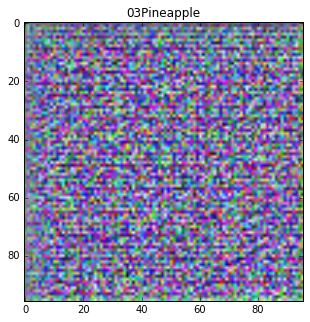

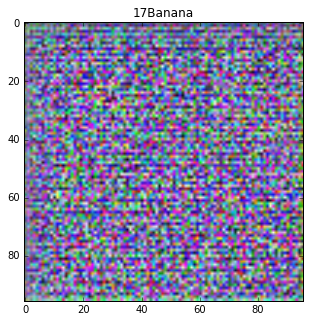

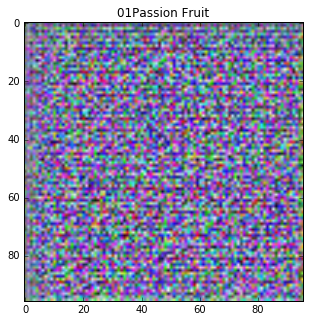

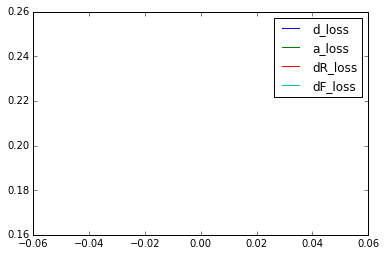

1
D1R
[0.12875351, 0.94568461]
D1F
[0.06719581, 0.95238107]
A1
[0.55588412, 0.90476215]
2


KeyboardInterrupt: 

In [28]:
for a in range(100000):
    print (a+0)
    TrainD()
    TrainG()
    if(a % 50 == 0):
        for b in range(3):
            name = 'img/'+str(a)+'-'+str(b)+'.png'
            Show(name)
        ShowPlt()

In [ ]:
#modelTD.load_weights('modelTD5_weights96.h5')
#modelTA.load_weights('modelTA5_weights96.h5')

In [ ]:
modelTD.save('modelDFruit96.h5') 
modelTA.save('modelTFruit96.h5') 
modelTD.save_weights('modelDFruit_weights96.h5')
modelTA.save_weights('modelAFruit_weights96.h5')


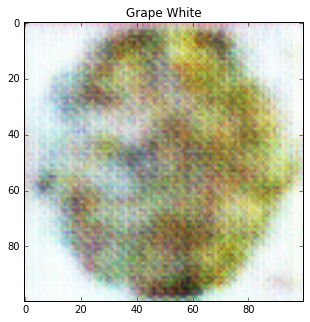

In [133]:
Show('k.png')
